In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score ,root_mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## **Part 2: Exploratory Data Analysis (EDA) and Preprocessing**

First 3 rows:
   age  sex  chest_pain_type  resting_blood_pressure  serum_cholestoral  \
0   70    1                4                     130                322   
1   67    0                3                     115                564   
2   57    1                2                     124                261   

   fasting_blood_sugar  resting_electrocardiographic_results  max_heart_rate  \
0                    0                                     2             109   
1                    0                                     2             160   
2                    0                                     0             141   

   exercise_induced_angina  oldpeak  st_segment  major_vessels  thal  \
0                        0      2.4           2              3     3   
1                        0      1.6           2              0     7   
2                        0      0.3           1              0     7   

   heart_disease  
0              2  
1              1  
2              2  

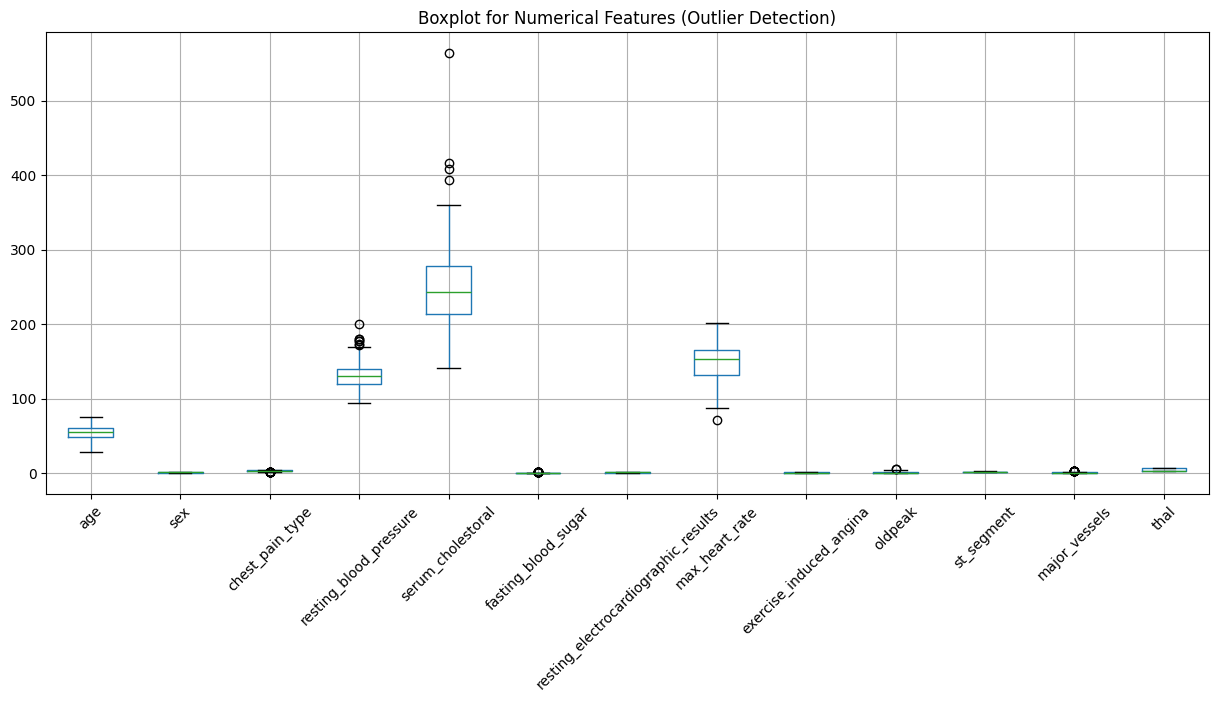


Outlier treatment completed using IQR capping.

Final Train Shape: (216, 13)
Final Test Shape: (54, 13)
heart_disease
0    150
1    120
Name: count, dtype: int64


In [23]:
# 1. Load data into Pandas DataFrame
df = pd.read_csv("/content/dataset_heart.csv")

# Clean column names (remove spaces, lowercase, underscores)
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# 2. Initial Inspection
print("First 3 rows:")
print(df.head(3))

print("\nDataset Shape (rows, columns):")
print(df.shape)

print("\nColumn Data Types:")
print(df.dtypes)

print("\nMissing Values per Column:")
print(df.isnull().sum())

# 3. Identify Target Variable
target = df.columns[-1]

# binary target (0 -> No disease, 1 -> Disease)
df[target] = df[target].map({1: 0, 2: 1})

print("\nTarget Variable:", target)

X = df.drop(columns=[target])
y = df[target]

# Identify numerical and categorical features
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

print("\nNumerical Features:", list(num_cols))
print("Categorical Features:", list(cat_cols))


# Train-Test Split (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Number of missing values {X_train.isnull().sum().sum()}")


# -------------------------------
# Outlier Detection (Optional but included)
# -------------------------------
# Boxplot visualization
plt.figure(figsize=(15, 6))
X_train[num_cols].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot for Numerical Features (Outlier Detection)")
plt.show()

# IQR Capping
for col in num_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X_train[col] = X_train[col].clip(lower_bound, upper_bound)
    X_test[col] = X_test[col].clip(lower_bound, upper_bound)

print("\nOutlier treatment completed using IQR capping.")

# ===============================
# Feature Scaling (Standardization)
# ===============================
# Re-identify numerical columns after encodingA
num_cols_scaled = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_train[num_cols_scaled] = scaler.fit_transform(X_train[num_cols_scaled])
X_test[num_cols_scaled] = scaler.transform(X_test[num_cols_scaled])

# ===============================
# Save Processed Dataset
# ===============================
train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_df.to_csv("/content/heart_train_processed.csv", index=False)
test_df.to_csv("/content/heart_test_processed.csv", index=False)


print("\nFinal Train Shape:", X_train.shape)
print("Final Test Shape:", X_test.shape)

print(df['heart_disease'].value_counts())

## **Part 3: Model Implementation and Evaluation**

### **6. Regression Task: Linear Regression (Predicting a Continuous Value)**

In [12]:
#Regression Task
# Define features (X) and target (y)
X = df.drop(columns=['age', 'heart_disease'])
y = df['age']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

Mean Squared Error (MSE): 66.11561034735753
Root Mean Squared Error (RMSE): 8.131150616447682
R2 Score: 0.16803410934659602


### **7. Classification Task: Logistic Regression**

In [13]:
# Classification Task (Logistic Regression)

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
# Define features and target
X = df.drop(columns=['heart_disease'])
y = df['heart_disease']

# Train-test split FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling (ONLY after split)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression
model = LogisticRegression(max_iter=1000)

# Train
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8518518518518519
Confusion Matrix:
 [[24  6]
 [ 2 22]]
Precision: 0.7857142857142857
Recall: 0.9166666666666666

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54



### **8. Clustering Task: K-Means Clustering**

Cluster
0    168
1    102
Name: count, dtype: int64


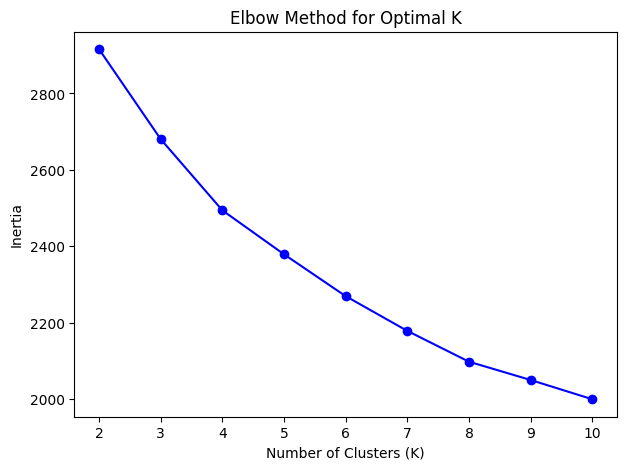

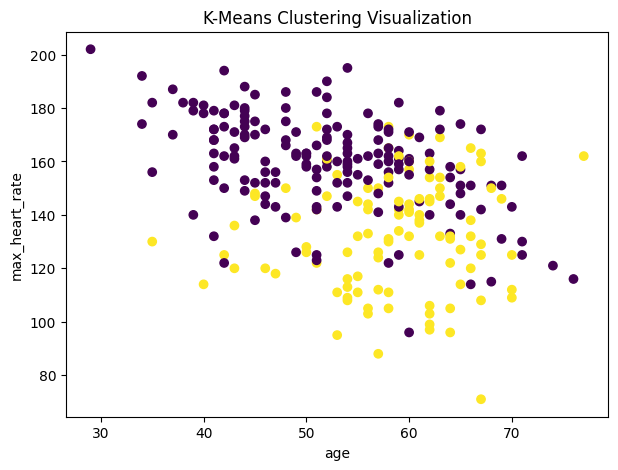

Shape of data without label: (270, 13)
Clustering completed with optimal K = 2
Number of clusters: 2
   age  sex  chest_pain_type  resting_blood_pressure  serum_cholestoral  \
0   70    1                4                     130                322   
1   67    0                3                     115                564   
2   57    1                2                     124                261   
3   64    1                4                     128                263   
4   74    0                2                     120                269   

   fasting_blood_sugar  resting_electrocardiographic_results  max_heart_rate  \
0                    0                                     2             109   
1                    0                                     2             160   
2                    0                                     0             141   
3                    0                                     0             105   
4                    0                          

In [21]:
#Clustering Task: K-Means Clustering

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define features and target
X = df.drop(columns=['heart_disease'])
y = df['heart_disease']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Optimal number of clusters (𝐾) using the Elbow Method
inertia = []
silScores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silScore = silhouette_score(X_scaled, kmeans.labels_)
    silScores.append(silScore) # Append the calculated silhouette score

optimalK = K_range[np.argmax(silScores)]

finalKmeans = KMeans(n_clusters=optimalK, random_state=42, n_init=10)
finalKmeans.fit(X_scaled)

df['Cluster'] = finalKmeans.labels_
print(df['Cluster'].value_counts())

# Calculate the Silhouette Score for the optimal K
silhouette_avg = silhouette_score(X_scaled, finalKmeans.labels_)

# Select two key features for visualization
feature_x = "age"
feature_y = "max_heart_rate"


plt.figure(figsize=(7, 5))
plt.plot(K_range, inertia, marker='o', color='blue')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(df[feature_x], df[feature_y], c=df["Cluster"])
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("K-Means Clustering Visualization")
plt.show()

# Print results
print("Shape of data without label:", X_scaled.shape)
print("Clustering completed with optimal K =", optimalK)
print("Number of clusters:", len(set(finalKmeans.labels_)))
print(df.head())
print("Silhouette Score for optimal K:", silhouette_avg)